In [16]:
from data_frame_manager.data_frame_manager import DataFrameManager
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
# import xgboost as xgb
import pandas as pd


DATASET_COLUMNS = ["text", "label"]
DATASET_ENCODING = "ISO-8859-1"

In [17]:
dataFrameManage = DataFrameManager()

train_df = dataFrameManage.load_dataframe(filepath="data/twitter-datasets/preprocessed/train_preprocessed.csv", encoding=DATASET_ENCODING, preprocess=False)
test_df = dataFrameManage.load_dataframe(filepath="data/twitter-datasets/preprocessed/test_preprocessed.csv", encoding=DATASET_ENCODING, preprocess=False)

encode_map = {"NEGATIVE" : 0, "POSITIVE" : 2}


train_labels = train_df["target"].map(encode_map).to_list()
test_labels = test_df["target"].map(encode_map).to_list()

# CountVectorizer

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

# We only keep the 5000 most frequent words, both to reduce the computational cost and reduce overfitting
vectorizer = CountVectorizer(max_features=5000)

# Important: we call fit_transform on the training set, and only transform on the validation set
X_train = vectorizer.fit_transform(train_df["text"].to_list())
X_val = vectorizer.transform(test_df["text"].to_list())

Y_train = train_labels
Y_val = test_labels

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(C=1e5, max_iter=100)
model.fit(X_train, Y_train)

In [ ]:
Y_train_pred = model.predict(X_train)
Y_val_pred = model.predict(X_val)

train_accuracy = accuracy_score(Y_train_pred, Y_train)
val_accuracy = accuracy_score(Y_val_pred, Y_val)
print(f'Accuracy (training set): {train_accuracy:.05f}')
print(f'Accuracy (validation set): {val_accuracy:.05f}')

# Twitter-roberta for sentiment analysis

In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW

In [10]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"

tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

### Fine tune the model with a small amount of the dataset

In [ ]:
model.classifier.loss_fn = nn.BCELoss()

# Split the dataset into training and evaluation sets
train_texts, eval_texts, train_lbls, eval_lbls = train_df["text"][:100000].to_list(), test_df["text"][:20000].to_list(), train_labels[:100000], test_labels[:20000]

# Tokenize the texts
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
eval_encodings = tokenizer(eval_texts, truncation=True, padding=True)


# Convert the dataset to PyTorch tensors
train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(train_encodings["input_ids"]),
    torch.tensor(train_encodings["attention_mask"]),
    torch.tensor(train_lbls)
)
eval_dataset = torch.utils.data.TensorDataset(
    torch.tensor(eval_encodings["input_ids"]),
    torch.tensor(eval_encodings["attention_mask"]),
    torch.tensor(eval_lbls)
)

# Define the optimizer and learning rate
optimizer = AdamW(model.parameters(), lr=1e-5)

# Fine-tuning loop
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
model.to(device)
model.train()

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
eval_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=16)

train_losses = []
eval_losses = []

train_accuracies = []
eval_accuracies = []

for epoch in tqdm(range(3)):  # Adjust the number of epochs as needed
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for step, batch in enumerate(train_loader):
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels = labels )
        
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        
        logits = outputs.logits
        l = torch.cat((logits[:, 0:1], logits[:, 2:]), dim=1)
        predicted_train_labels = torch.where(torch.argmax(l, dim=1) == 1, torch.tensor([2], device = device), torch.tensor([0], device = device))

        correct_train += (predicted_train_labels == labels).sum().item()
        total_train += labels.size(0)
        
    epoch_train_accuracy = correct_train / total_train
    print(f"Epoch {epoch+1} Train accuracy : {epoch_train_accuracy}")
    train_accuracies.append(epoch_train_accuracy)
        
    # Calculate and store training loss for the epoch
    epoch_train_loss = running_train_loss / total_train
    train_losses.append(epoch_train_loss)
    print(f"Epoch {epoch+1} Train Loss: {epoch_train_loss}")

    # Calculate and store validation loss for the epoch
    model.eval()
    eval_loss = 0.0
    
    eval_total = 0
    correct_eval = 0

    with torch.no_grad():
        for eval_batch in eval_loader:
            eval_input_ids, eval_attention_mask, eval_labels = eval_batch
            eval_input_ids = eval_input_ids.to(device)
            eval_attention_mask = eval_attention_mask.to(device)
            eval_labels = eval_labels.to(device)

            eval_outputs = model(eval_input_ids, attention_mask=eval_attention_mask, labels = eval_labels)
            eval_loss += eval_outputs.loss.item()
            eval_total += eval_labels.size(0)

            logits = eval_outputs.logits
            l = torch.cat((logits[:, 0:1], logits[:, 2:]), dim=1)
            predicted_eval_labels = torch.where(torch.argmax(l, dim=1) == 1, torch.tensor([2], device = device), torch.tensor([0], device = device))
            
            correct_eval += (predicted_eval_labels == eval_labels).sum().item()
            
    epoch_eval_loss = eval_loss / eval_total
    eval_losses.append(epoch_eval_loss)

    print(f"Epoch {epoch+1} Eval Loss: {epoch_eval_loss}")

    epoch_eval_accuracy = correct_eval / eval_total
    print(f"Epoch {epoch+1} Eval accuracy : {epoch_eval_accuracy}")

    eval_accuracies.append(epoch_eval_accuracy)

    model.train()

# Evaluation
model.eval()
model.save_pretrained("twitter-roberta-base-sentiment-latest-BCELoss")




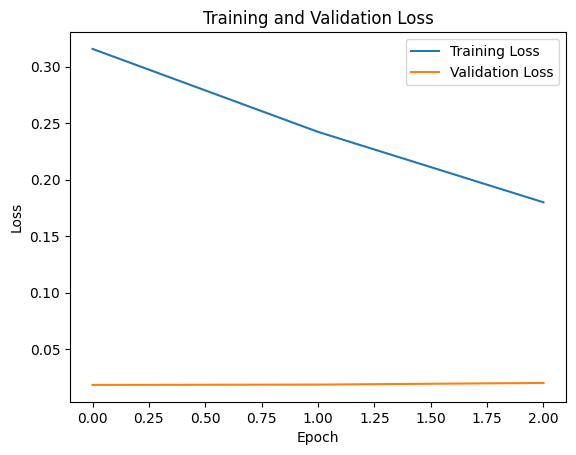

In [10]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.plot(train_losses, label="Training Loss")
plt.plot(eval_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()


## Import the finetuned model

In [5]:
task = 'sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained("twitter-roberta-base-sentiment")
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

### Make the prediction with the imported model

In [20]:
val_df = dataFrameManage.load_dataframe(filepath="data/twitter-datasets/preprocessed/test_data_preprocessed.csv", encoding=DATASET_ENCODING, preprocess=False, test = True)
eval_encodings = tokenizer(val_df["text"].to_list(), truncation=True, padding=True)
eval_dataset = torch.utils.data.TensorDataset(
    torch.tensor(eval_encodings["input_ids"]),
    torch.tensor(eval_encodings["attention_mask"])
)
eval_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=32)

In [ ]:
preds = []
model.eval()
with torch.no_grad():

    for batch in eval_loader:
        input_ids, attention_mask = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits   
        l = torch.cat((logits[:, 0:1], logits[:, 2:]), dim=1)
        predicted_labels = np.where(torch.argmax(l, dim=1) == 1, 2, 0)
        preds.append(predicted_labels)

preds = torch.cat(preds, dim=0)

preds_array = preds.cpu().numpy()

print(preds_array)



In [10]:
np.unique(preds_array)

array([0, 1])

In [25]:
mapped_array = np.where(preds_array == 0, -1, 1)

print(mapped_array)

[-1 -1  1 ... -1  1 -1]


In [26]:
predict_df = pd.DataFrame(mapped_array, columns=["Prediction"], index=pd.Index(range(1, len(mapped_array)+1), name="Id"))
predict_df.to_csv(f"data/twitter-datasets/predictions_twitter-roberta-base-sentiment.csv", index=True, index_label="Id")

# Bertweet

In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer, AdamW

In [ ]:
import torch
import torch.nn as nn

class Classifier(nn.Module):
    def __init__(self, model, num_classes, hidden_size=768):
        super(Classifier, self).__init__()
        self.model = model
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(hidden_size, num_classes)
        self.loss_function = nn.CrossEntropyLoss()
        self.epoch = 0

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        cls = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(cls)

        if labels is not None:
            loss = self.loss_function(logits, labels)
            return loss, logits
        else:
            return logits

    def save_model(self, file_path):
        state = {
            'epoch': self.epoch,
            'model_state_dict': self.model.state_dict(),
            'classifier_state_dict': self.classifier.state_dict(),
        }
        torch.save(state, file_path)

    def load_model(self, file_path):
        state = torch.load(file_path)
        self.epoch = state['epoch']
        self.model.load_state_dict(state['model_state_dict'])
        self.classifier.load_state_dict(state['classifier_state_dict'])



In [ ]:
from data_frame_manager.data_frame_manager import DataFrameManager
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import pandas as pd


DATASET_COLUMNS = ["text", "label"]
DATASET_ENCODING = "ISO-8859-1"
MODEL_NAME = 'roberta'
NUM_CLASSES = 3

dataFrameManage = DataFrameManager()

train_df = dataFrameManage.load_dataframe(filepath="../SentimentAnalysis/data/twitter-datasets/preprocessed/train_preprocessed.csv", encoding=DATASET_ENCODING, preprocess=False)
test_df = dataFrameManage.load_dataframe(filepath="../SentimentAnalysis/data/twitter-datasets/preprocessed/test_preprocessed.csv", encoding=DATASET_ENCODING, preprocess=False)

encode_map = {"NEGATIVE" : 0, "POSITIVE" : 1}


train_labels = train_df["target"].map(encode_map).to_list()
test_labels = test_df["target"].map(encode_map).to_list()


In [ ]:

config = {
    "models" : {
        "bertweet_1" : AutoModel.from_pretrained("vinai/bertweet-base"),
        "bertweet_2" : AutoModel.from_pretrained("vinai/bertweet-base"),
        "bertweet_3" : AutoModel.from_pretrained("vinai/bertweet-base"),
    },
    "tokenizer" : AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False),
}

In [ ]:
tokenizer = config["tokenizer"]
num_models = 3
len_train = 100000
len_test = 20000
for j in  tqdm(range(1,num_models + 1)):
    print(f"Model {j}")
    bertweet = config["models"][f"bertweet_{j}"]
    train_texts, eval_texts, train_lbls, eval_lbls = train_df["text"][len_train * (j-1) :len_train*j].to_list(), test_df["text"][:len_test].to_list(), train_labels[len_train * (j-1) :len_train*j], test_labels[:len_test]

    
    train_encodings = tokenizer(train_texts, truncation=True, padding=True)
    eval_encodings = tokenizer(eval_texts, truncation=True, padding=True)

    train_dataset = torch.utils.data.TensorDataset(
        torch.tensor(train_encodings["input_ids"]),
        torch.tensor(train_encodings["attention_mask"]),
        torch.tensor(train_lbls)
    )
    eval_dataset = torch.utils.data.TensorDataset(
        torch.tensor(eval_encodings["input_ids"]),
        torch.tensor(eval_encodings["attention_mask"]),
        torch.tensor(eval_lbls)
     )
    
    # Fine-tuning loop
    device = torch.device("cuda" if torch.cuda.is_available() else "mps")
    model = Classifier(bertweet, 2)
    optimizer = AdamW(model.parameters(), lr=1e-5)
    model.to(device)
    model.train()
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
    eval_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=16)
    
    train_losses = []
    eval_losses = []
    
    train_accuracies = []
    eval_accuracies = []

    best_eval_accuracy = float("-inf")
    best_model_path = None

    patience = 3  # Number of epochs to wait for improvement
    no_improvement_count = 0
    
    for epoch in tqdm(range(10)):
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        
        model.train()
        
        for step, batch in enumerate(train_loader):
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)
    
            optimizer.zero_grad()
            loss, logits = model(input_ids, attention_mask=attention_mask, labels = labels )
            
            loss.backward()
            optimizer.step()
    
            running_train_loss += loss.item()
                   
            predicted_train_labels = torch.argmax(logits, dim=1)
    
            correct_train += (predicted_train_labels == labels).sum().item()
            total_train += labels.size(0)
    
        model.epoch = epoch
    
        epoch_train_accuracy = correct_train / total_train
        print(f"Epoch {epoch+1} Train accuracy : {epoch_train_accuracy}")
        train_accuracies.append(epoch_train_accuracy)
            
        # Calculate and store training loss for the epoch
        epoch_train_loss = running_train_loss / total_train
        train_losses.append(epoch_train_loss)
        print(f"Epoch {epoch+1} Train Loss: {epoch_train_loss}")
    
        # Calculate and store validation loss for the epoch
        model.eval()
        eval_loss = 0.0
        
        eval_total = 0
        correct_eval = 0
    
        with torch.no_grad():
            for eval_batch in eval_loader:
                eval_input_ids, eval_attention_mask, eval_labels = eval_batch
                eval_input_ids = eval_input_ids.to(device)
                eval_attention_mask = eval_attention_mask.to(device)
                eval_labels = eval_labels.to(device)
    
                loss, logits = model(eval_input_ids, attention_mask=eval_attention_mask, labels = eval_labels)
                eval_loss += loss.item()
                eval_total += eval_labels.size(0)
    
                # logits = eval_outputs.logits
                predicted_eval_labels = torch.argmax(logits, dim=1)
                
                correct_eval += (predicted_eval_labels == eval_labels).sum().item()
                
        epoch_eval_loss = eval_loss / eval_total
        eval_losses.append(epoch_eval_loss)
    
        print(f"Epoch {epoch+1} Eval Loss: {epoch_eval_loss}")
    
        epoch_eval_accuracy = correct_eval / eval_total
        print(f"Epoch {epoch+1} Eval accuracy : {epoch_eval_accuracy}")
    
        eval_accuracies.append(epoch_eval_accuracy)
        if epoch_eval_accuracy > best_eval_accuracy:
            best_eval_accuracy = epoch_eval_accuracy
            model.save_model(f'full_sparsemax_bertweet_{j}.pt')
            no_improvement_count = 0  # Reset the counter
        else:
            no_improvement_count += 1
        
        if no_improvement_count >= patience:
            print("Early stopping triggered. No improvement in validation loss.")
            break      
        model.train()
    


In [ ]:
tokenizer = config["tokenizer"]
len_test = 20000

eval_texts, eval_lbls = test_df["text"][:len_test].to_list(), test_labels[:len_test]
print(len(eval_texts))
eval_encodings = tokenizer(eval_texts, truncation=True, padding=True)
eval_dataset = torch.utils.data.TensorDataset(
                torch.tensor(eval_encodings["input_ids"]),
                torch.tensor(eval_encodings["attention_mask"]),
                torch.tensor(eval_lbls)
             )
eval_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=16)
tokenizer = config["tokenizer"]
device = torch.device("cuda" if torch.cuda.is_available() else "mps")

predicted = []
for j in  range(1,4):
    model = Classifier(AutoModel.from_pretrained("vinai/bertweet-base"),2)
    model.load_model(f"full_sparsemax_bertweet_{j}.pt")
    model.to(device)
    temp = []
    eval_loss = 0.0
        
    eval_total = 0
    correct_eval = 0
    with torch.no_grad():
        for eval_batch in eval_loader:
            eval_input_ids, eval_attention_mask, eval_labels = eval_batch
            eval_input_ids = eval_input_ids.to(device)
            eval_attention_mask = eval_attention_mask.to(device)
            eval_labels = eval_labels.to(device)
    
            loss, logits = model(eval_input_ids, attention_mask=eval_attention_mask, labels = eval_labels)
            eval_loss += loss.item()
            eval_total += eval_labels.size(0)
    
            # logits = eval_outputs.logits
            predicted_eval_labels = torch.argmax(logits, dim=1)
            temp.append(predicted_eval_labels)
        predicted.append(torch.cat(temp, dim=0).cpu().numpy())

In [ ]:
def majority_vote(predicted):
    return np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=predicted)
    
def weighted_majority_vote(predictions, weights):
    weighted_votes = [predictions[i] * weights[i] for i in range(len(predictions))]

    aggregated_votes = np.sum(weighted_votes, axis=0)

    final_prediction = np.where(aggregated_votes >= (sum(weights) / 2), 1, 0)

    return final_prediction

In [ ]:
preds = predicted
majority = majority_vote(predicted)
print("Majority ", (torch.from_numpy(majority).to(device) == torch.tensor(eval_lbls,device=device)).sum().item()/len(majority))

weighted_majority = weighted_majority_vote(preds, [0.4,0.3, 0.3])
print("Weighted majority ", (torch.from_numpy(weighted_majority).to(device) == torch.tensor(eval_lbls,device=device)).sum().item()/len(weighted_majority))
